## Analyze A/B Test Results

We are conducting this project Analyze A/B Test Results to analyze the behavior of two versions of a webpage old and new to determine if we can statistically prove whether one is better than the other.

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

For this project, we will be working to understand the results of an A/B test run by an e-commerce website. We will use the raw data collected for both old and new versions of our webpage, set up our hypothesis and use statistics to either reject or accept the null hypothesis. Our goal is to use the ab_data and through A/B testing analysis help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


In [1]:
# To get started, let's import our libraries.

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

In [2]:
# Now, let's read in the ab_data.csv data. Store it in df and take a look at the top few rows.
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


### Data Exploration

>> 1. Let's explore the data to find out size of the dataset, number of unique users and if there any any missing
      values or duplicates.
>> 2. Find out if there are any rows where the group and landing page doesn't match.
>> 3. Also, let's find out probabilities using raw data

In [3]:
# Finding out size(number of rows and columns) of our ab_data dataset.
df.shape

(294478, 5)

In [4]:
# Let's find out number of unique users in the dataset.
df['user_id'].nunique()

290584

In [5]:
# finding the proportion of users converted
df.query('converted == 1').user_id.nunique()/df.user_id.nunique()

0.12104245244060237

In [6]:
# Find out if there are any rows where the new_page and treatment group don't match
df.query('group == "treatment" and landing_page != "new_page"').user_id.nunique() + df.query('landing_page == "new_page" and group != "treatment"').user_id.nunique()

3893

In [7]:
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].user_id.nunique()

3893

In [8]:
#find more information about the dataset like any missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [9]:
# Find out how many duplicate rows are present in the data set
sum(df.duplicated())

0

### Data Cleaning

>> 1. For the rows where **treatment** does not match with **new_page** or **control** does not match with
      **old_page**, we cannot be sure if this row truly received the new or old page. Let's exclude the rows
      where the mismatch occurs. 
>> 2. Remove any duplicate users
>> 3. Store the clean data in a new dataframe

In [10]:
# Exclude the rows where group and landing pages doesn't match.
# Store the filtered data in the dataframe df2
df2 = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == True]

In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [12]:
# Finding number of unique users in our filtered dataset df2
df2.user_id.nunique()

290584

In [13]:
# Shape of the filtered data df2
df2.shape

(290585, 5)

In [14]:
# Taking a look at first few rows of df2
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [15]:
# Checking if there are any duplicate users
df2.duplicated(['user_id']).sum()

1

In [16]:
# Checking if there are any duplicate rows
df2.duplicated().sum()

0

In [17]:
# Finding out the duplicate users and the row information
df2.loc[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [18]:
# Removing the rows with duplicate user_ids
df2 = df2.drop_duplicates(['user_id'])
# Checking the number of rows after removing duplicates
df2.shape

(290584, 5)

In [19]:
# Taking a look at df2 after removing the duplicates
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


<a id='ab_test'></a>
### Part I - Probability
>> Using the clean dataset:
>> 1. Let's find out overall probability of users converting and also from both the 'control' and 'treatment'
      groups.
>> 2. Find out probability of users who received the new page as well

In [20]:
# Finding out the probability of an individual converting regardless of the page they receive
df2.query('converted == "1"')['user_id'].count()/df2.shape[0]

0.11959708724499628

In [21]:
# Finding out the probability of individuals from the control group converting
df2.query('group == "control" and converted == "1"')['user_id'].count()/df2.query('group == "control"')['user_id'].count()

0.1203863045004612

In [22]:
# Finding out the probability of individuals from the treatment group converting
df2.query('group == "treatment" and converted == "1"')['user_id'].count()/df2.query('group == "treatment"')['user_id'].count()

0.11880806551510564

In [23]:
# Finding out the probability of individuals who received the new page
df2.query('landing_page == "new_page"')['user_id'].count()/df2.shape[0]

0.5000619442226688

**Based on the above results**

>> Users who received new and old page are almost same, 50%.
>> Overall, the probability of users converting regardless of what page they receive is around 12%.
>> If we look at the probabilities of users from both 'control' and 'treatment' groups converting, we can see
   that there is a little decrease in the conversions for users who received the new page, which is close to 1%.
>> 1% difference is not high enough to conclude that any of the the pages leads to more or less conversions.

<a id='ab_test'></a>
### Part II - A/B Test 

>> As we know, our initial observation(in this case the above statement) is not a substantial evidence which will
   prove that one page is considered significantly better than another. 
>> We can use sampling distribution try to see if it aligns with our null hypothesis.
   if the test gives us clearer picture of any page being better than the other.
>> For now, let's assume under the null hypothesis, both old and new pages have similar success rate, which is
   same as the overall converted success rate ragardless of the landing page.
>> Our alternate hypothesis would be that there is significant difference between the converted rate for the old
   and new page.
   
$$H_0: \mu_{new} - \mu_{old} = 0$$


$$H_1: \mu_{new} - \mu_{old} \neq 0$$

>> 1. Let's use the clean data that we have prepared 
>> 2. Use a sample with a same size for each page equal to the ones in our dataset df2.  

In [24]:
# converted rate in clean ab_data.csv regardless of the landing page
# Assumption is they are equal to the converted rate regardless oh the page
df2.query('converted == "1"')['user_id'].count()/df2.shape[0]

0.11959708724499628

In [25]:
# Under the null both p_old and p_new are equal.
# conversion rate for 𝑝_new under the null
p_new = df2.converted.mean()
p_new

0.11959708724499628

In [26]:
# Under the null both p_old and p_new are equal.
# Conversion rate for  𝑝_𝑜𝑙𝑑 under the null
p_old = df2.converted.mean()
p_old

0.11959708724499628

In [27]:
#converted rate in clean ab_data.csv regardless of the landing page
df2.query('converted == "1"')['user_id'].count()/df2.shape[0]

0.11959708724499628

In [28]:
# number of individuals in the treatment group
n_new = df2.query('group == "treatment"')['user_id'].count()
n_new

145310

In [29]:
# number of individuals in the control group
n_old = df2.query('group == "control"')['user_id'].count()
n_old

145274

In [30]:
# Simulate 𝑛_𝑛𝑒𝑤 transactions with a conversion rate of 𝑝_𝑛𝑒𝑤 under the null. 
# Store these 𝑛_𝑛𝑒𝑤 1's and 0's in new_page_converted.
new_page_converted = np.random.binomial(1, p_new, n_new)

In [31]:
# proportion of converted based on users landed on the new page
new_cnv_rate = (new_page_converted).mean()
new_cnv_rate

0.11819558185947285

In [32]:
# Simulate 𝑛_old transactions with a conversion rate of 𝑝_old under the null. 
# Store these 𝑛_old 1's and 0's in old_page_converted.
old_page_converted = np.random.binomial(1, p_old, n_old)

In [33]:
# proportion of converted based on users landed on the old page
old_cnv_rate = (old_page_converted).mean()
old_cnv_rate

0.11911973236780153

In [34]:
# Find the observed difference (p_new - p_old) for above simulated values.
obs_diffs = (new_cnv_rate - old_cnv_rate)
obs_diffs

-0.0009241505083286833

> As per above results, it looks like conversion rate for the old page is little bit higher(still very close to
  0) than that for the new page. 
> We need to check if this difference is significant and just due to a chance.|

> **Bootstapping** : We can further test the above observation by bootstrapping the sample by simulating the 
  sampling distribution for the difference in proportion. 
> Simulate the sampling distribution and create 10,000 $p_{new}$ - $p_{old}$ values. Store all 10,000 values in a
  NumPy array called **p_diffs**.

In [35]:
# create an empty list p_diffs to store the rate differences
# Use a loop with 10000 transactions to test the 10000 random samples to calcute the conversion rates for both old and new pages
# Sampling distribution
p_diffs = []
# Calculate the conversion rate for old and new 
new_cnv_sim_rate = np.random.binomial(n_new, p_new, 10000)/n_new
old_cnv_sim_rate = np.random.binomial(n_old, p_old, 10000)/n_old
# Calculate the difference
p_diffs = (new_cnv_sim_rate - old_cnv_sim_rate)


In [36]:
# Convert p_diffs into an array
p_diffs = np.array(p_diffs)

In [37]:
p_diffs

array([ 0.00113366, -0.00048389, -0.00074532, ..., -0.00137175,
       -0.00050454, -0.00112403])

In [38]:
p_diffs.mean()

-2.484343291792224e-05

In [39]:
p_diffs.std()

0.001202807353108472

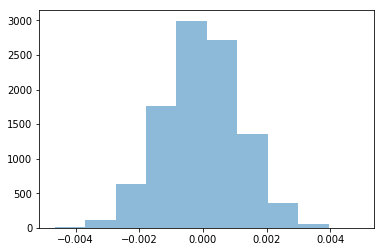

In [40]:
# Plot a histogram of the p_diffs. Does this plot look like what you expected? 
plt.hist(p_diffs, alpha=0.5);

> The sampling distribution is normal. Our hypothesis is consistent with what we observed in our sampling 
  distribution. The mean difference is centered towards 0.

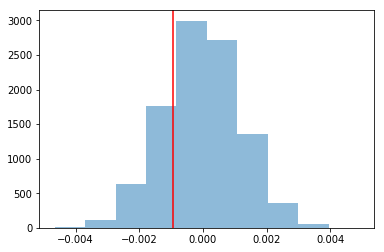

In [41]:
# Plot the null_vals and the observed difference 
plt.hist(p_diffs, alpha=0.5);
plt.axvline(obs_diffs, color='Red');

In [42]:
# We compute the p-value by finding the proportion of values in the null distribution 
# that were greater than our observed difference.
(p_diffs > obs_diffs).mean()

0.77

> Above proportion of values in the null distribution that were greater than our observed difference gives us a 
  **p value**. In this case it is high close to **0.77**. We use this p-value to determine the statistical 
  significance of our observed difference. This high p-value(>0.05) shows that there is not enough evidence to 
  prove that the new page is better than old page when it comes to conversions. We shouldn't move away from the
  null hypothesis.

> The definition of a p-value is the probability of observing your statistic (or one more extreme in favor of the
  alternative) if the null hypothesis is true.


### statsmodels - to calculate p and z values 


In [43]:
# import all the required statistic packages
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest
# number of conversions for each page
convert_old = df2.query('group == "control" and converted=="1"')['user_id'].count()
convert_new = df2.query('group == "treatment" and converted=="1"')['user_id'].count()
# number of individuals who received each page.
n_old = df2.query('group == "control"')['user_id'].count()
n_new = df2.query('group == "treatment"')['user_id'].count()

In [44]:
# use stats.proportions_ztest to compute your test statistic and p-value.
zval, pval = sm.stats.proportions_ztest([convert_new, convert_old],[n_new, n_old], alternative='larger')
print('{0:0.3f}'.format(zval))
print('{0:0.3f}'.format(pval))

-1.311
0.905


> **z-score** is the number of standard deviation a data point is from the population mean. In this case z-score is **-1.311** for the conversion rates of the old and new pages is high and we cannot reject the null hypothesis.

> **p-value** is the significance of our result, **0.905** is very high in comparison with 0.05.
> Above calculated p-value(0.995) is close to what we found out from simulated null p-value, which shows that we cannot reject the null hypothesis and cannot significanly say that any of the page better than the other.

<a id='regression'></a>
### Part III - A regression approach

We can also take a **Logistic regression** model approach to find out if the users from new and old page gets converted or not. conversion rates have any significant difference.


>  The goal is to use **statsmodels** to fit the **logistic regression model** to see if there is a significant
   difference in conversion based on which page a customer receives. 

In [45]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [46]:
# Create a dumy column 'intercept' and assign value to 1
df2['intercept']=1
# create a dumy column 'ab_page',which is 1 when an individual receives the **treatment** and 0 if **control**.
df2[['control', 'ab_page']]=pd.get_dummies(df2['group'])
df2.drop(labels=['control'], axis=1, inplace=True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [47]:
# Use statsmodels to instantiate logistic regression model on the two columns we created
lm = sm.Logit(df2['converted'], df2[['intercept','ab_page']])

In [48]:
# Fit the model and assign the result
results = lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [49]:
# Show the summary of the results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 16 Jan 2020   Pseudo R-squ.:               8.077e-06
Time:                        17:07:03   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [50]:
# coefficient for ab_page is less than 1 so we need to obtain the reciprocal
1/np.exp(-0.0150)

1.015113064615719

> Conversion is **1.015** times as likely for users from treatment group than control group.

> The p-value associated with **ab_page** is **0.19** which is higher than **0.05**. We cannot say that there is significant eveidence to prove that conversion rate for any of the new and old page is greater than other.

> Considering more explanotory variables makes our hypothesis results more reliable.
> Also it will increase chance of multicollinearity which can be a disadvantage because it can undermine the significance of an independant variable.
> The disadvantages of adding additional terms into your regression model is, the more metrics you evaluate, the
  more likely you are to observe significant differences just by chance. We are going to keep the other variables constant.

> **Does country have any impact on convertion?** 
 

In [51]:
# Read the countries.csv file and assign it to a dataframe 
df3 = pd.read_csv('countries.csv')
df3.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [52]:
# Merge both the dataframes keeping the same index using a column name
df2 = df2.join(df3.set_index('user_id'), on='user_id')
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [53]:
df2['country'].unique()

array(['US', 'CA', 'UK'], dtype=object)

In [54]:
# No need to create the column intercept again
# create dummy variables to represent a country
df2[['CA','UK','US']]=pd.get_dummies(df2['country'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1


In [55]:
# Use statsmodels to instantiate logistic regression model on the two columns we created, keeping the third as a baseline
lm2 = sm.Logit(df2['converted'], df2[['intercept','CA','US']])

In [56]:
# Fit the model and assign the result
results = lm2.fit()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


In [57]:
# Show the summary of the results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Thu, 16 Jan 2020   Pseudo R-squ.:               1.521e-05
Time:                        17:07:04   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9868      0.011   -174.174      0.000      -2.009      -1.964
CA            -0.0507      0.028     -1.786      0.074      -0.106       0.005
US            -0.0099      0.013     -0.746      0.456      -0.036       0.016
==============================================================================
"""

> Looking at the p-value for CA and US which are **0.074** and **0.455** we cannot say that country has any 
  impact on conversion

### Conclusion
> Looking at above hypothesis testing where due to p-value being way higher than acceptable 0.05, we can say that there is no significant evidence to prove that any page between old and new is better than the other, and has no impact on the conversion. It won't be beneficial to implement this change.